In [ ]:
#Import the data

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import csv

# Define the file path

path_raw_recipes = '/content/drive/My Drive/Master_Thesis/Food.com_RAW_recipes.csv'
path_raw_interactions = '/content/drive/My Drive/Master_Thesis/Food.com_RAW_interactions.csv'


# Create an empty list to store the recipe data
data_recipes = []

# Open and read the file line-by-line
with open(path_raw_recipes, newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
      data_recipes.append(row)

# Create the DataFrame with specified column names
df_recipes = pd.DataFrame(data_recipes, columns=["name", "recipe_id", "minutes", "contributor_id", "submitted", "tags", "nutrition", "n_steps", "steps", "description", "ingredients", "n_ingredients"])
df_recipes = df_recipes.drop(0).reset_index(drop=True)


# Display a sample of the dataset to check the structure
print(df_recipes.head())


# Create an empty list to store the interaction data
data_interactions = []

# Open and read the file line-by-line
with open(path_raw_interactions, newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
      data_interactions.append(row)

# Create the DataFrame with specified column names
df_interactions = pd.DataFrame(data_interactions, columns=["user_id", "recipe_id", "date", "rating", "review"])
df_interactions = df_interactions.drop(0).reset_index(drop=True)


# Display a sample of the dataset to check the structure
print(df_interactions.head())


                                         name recipe_id minutes  \
0  arriba   baked winter squash mexican style    137739      55   
1            a bit different  breakfast pizza     31490      30   
2                   all in the kitchen  chili    112140     130   
3                          alouette  potatoes     59389      45   
4          amish  tomato ketchup  for canning     44061     190   

  contributor_id   submitted  \
0          47892  2005-09-16   
1          26278  2002-06-17   
2         196586  2005-02-25   
3          68585  2003-04-14   
4          41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition n_steps  \
0       [5

In [ ]:
import pandas as pd

df_merge = pd.merge(df_recipes, df_interactions, on="recipe_id")
df_merge.drop_duplicates(subset=['steps', 'description'], inplace=True)
df_merge.reset_index(drop=True, inplace=True)
df = df_merge[["ingredients", "steps", "rating"]]
print(df)

                                              ingredients  \
0       ['winter squash', 'mexican seasoning', 'mixed ...   
1       ['prepared pizza crust', 'sausage patty', 'egg...   
2       ['ground beef', 'yellow onions', 'diced tomato...   
3       ['spreadable cheese with garlic and herbs', 'n...   
4       ['tomato juice', 'apple cider vinegar', 'sugar...   
...                                                   ...   
231595  ['celery', 'onion', 'green sweet pepper', 'gar...   
231596  ['paprika', 'salt', 'garlic powder', 'onion po...   
231597  ['hard-cooked eggs', 'mayonnaise', 'dijon must...   
231598  ['butter', 'eagle brand condensed milk', 'ligh...   
231599  ['granulated sugar', 'shortening', 'eggs', 'fl...   

                                                    steps rating  
0       ['make a choice and proceed with recipe', 'dep...      5  
1       ['preheat oven to 425 degrees f', 'press dough...      0  
2       ['brown ground beef in large pot', 'add choppe...      4  

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np

"""
Create Bert embeddings for the recipe dataset

"""


# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to('cuda' if torch.cuda.is_available() else 'cpu')

def generate_bert_embeddings(batch_texts, tokenizer, model, max_len=512):
    """
    Generate BERT embeddings for a batch of text inputs.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Tokenize and encode the batch of texts
    inputs = tokenizer(
        batch_texts,
        return_tensors="pt",
        max_length=max_len,
        truncation=True,
        padding="max_length"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        cls_embeddings = outputs.pooler_output  # Use [CLS] token's embedding (batch_size, 768)

    return cls_embeddings.cpu().numpy()

def format_input(ingredients, steps):
    return f"<ingredients> {ingredients} </ingredients>, <steps> {steps} </steps>"

# Parameters
batch_size = 32
save_path = '/content/drive/My Drive/Master_Thesis/bert_embeddings2.npy'

# Format dataset (assume `df` contains your data)
steps_and_ingredients = [
    format_input(ingredients, steps)
    for ingredients, steps in zip(df['ingredients'], df['steps'])
]

# Initialize the list to collect the embeddings
bert_embeddings = []

# Process data in batches
for i in tqdm(range(0, len(steps_and_ingredients), batch_size)):
    batch_texts = steps_and_ingredients[i:i+batch_size]

    # Generate embeddings for the batch (all at once)
    batch_embeddings = generate_bert_embeddings(batch_texts, tokenizer, bert_model)

    # Add batch embeddings to the final list
    bert_embeddings.append(batch_embeddings)

# Stack all embeddings into one array
bert_embeddings = np.vstack(bert_embeddings)  # Shape will be (231600, 768)

# Save all embeddings
np.save(save_path, bert_embeddings)
print(f"All {bert_embeddings.shape[0]} embeddings saved successfully to {save_path}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
2895/2895 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 2.6045 - mae: 1.3114 - val_loss: 0.3351 - val_mae: 0.3173 - learning_rate: 1.0000e-05
Epoch 2/50
2895/2895 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.7588 - mae: 1.0278 - val_loss: 0.3731 - val_mae: 0.3846 - learning_rate: 1.0000e-05
Epoch 3/50
2895/2895 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.5050 - mae: 0.9231 - val_loss: 0.3683 - val_mae: 0.3864 - learning_rate: 1.0000e-05
Epoch 4/50
2895/2895 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.4206 - mae: 0.8713 - val_loss: 0.3768 - val_mae: 0.3993 - learning_rate: 1.0000e-05
Epoch 5/50
2895/2895 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.2718 - mae: 0.8237 - val_loss: 0.4134 - val_mae: 0.4450 - learning_rate: 1.0000e-05
Epoch 6/50
2895/2895 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.2714 - mae: 0.8036 - val_loss: 0.3541 - val_mae: 0.3703 - learning_rate: 1.0000e-05
Epoch 7/50
2895/2895 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.1526 - mae: 0.7785 - val_loss: 0.4082 - val_m

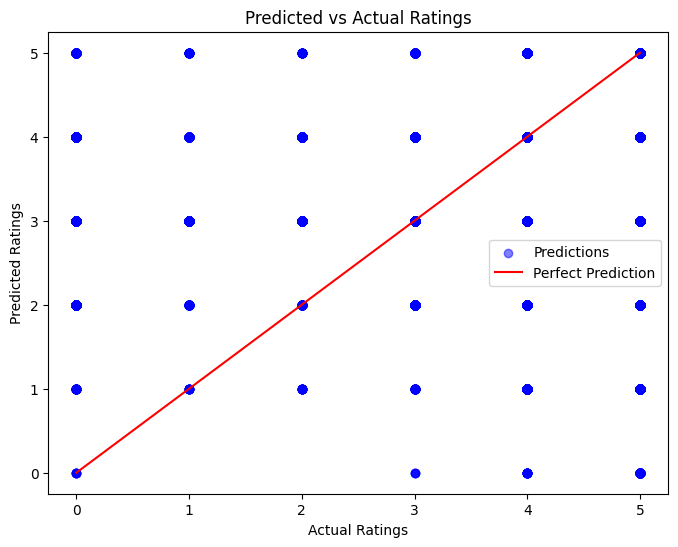

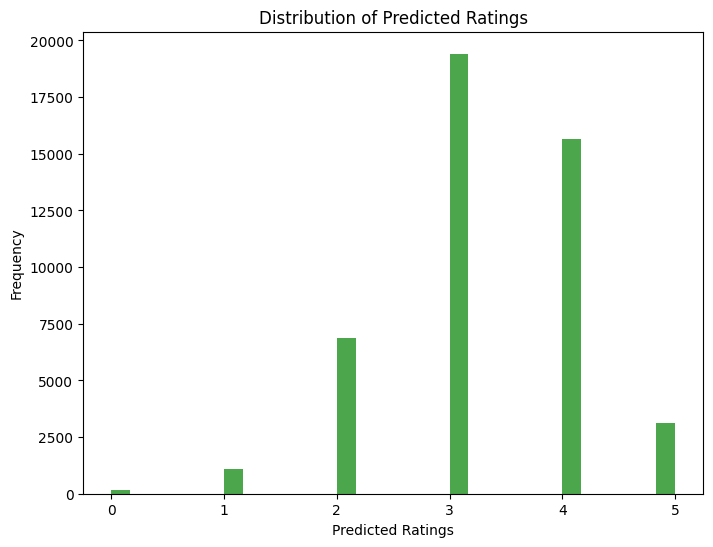

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber, MeanSquaredError
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_sample_weight

# Set random seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

# Load data
ratings = pd.to_numeric(df['rating'], errors='coerce').dropna()
bert_embeddings = np.load('/content/drive/My Drive/Master_Thesis/bert_embeddings2.npy')

# Scale ratings between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
ratings_scaled = scaler.fit_transform(ratings.values.reshape(-1, 1)).flatten()

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    bert_embeddings, ratings_scaled, test_size=0.2, random_state=42
)

# Residual Block with L2 Regularization
def residual_block(x, units, l2_reg=1e-4):
    shortcut = x
    x = Dense(units, activation=None, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = LeakyReLU(alpha=0.3)(x)  # Using LeakyReLU activation instead of ReLU
    x = BatchNormalization()(x)
    x = Dense(units, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.3)(x)  # Using LeakyReLU activation here as well
    return x

# Build the Neural Network Model
def build_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(512, activation=None, kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = LeakyReLU(alpha=0.3)(x)  # Using LeakyReLU activation
    x = residual_block(x, 512)
    x = Dropout(0.5)(x)
    x = Dense(256, activation=None, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = LeakyReLU(alpha=0.3)(x)  # Using LeakyReLU activation
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='linear')(x)  # Regression output
    model = Model(inputs, outputs)
    return model

# Train and Evaluate Model
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    optimizer = Adam(learning_rate=1e-5)  # Lower learning rate
    model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Compute sample weights for imbalanced classes
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Modify the loss function to use weighted loss
    model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mae'])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        sample_weight=sample_weights,  # Include sample weights during training
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

    y_pred = model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"RMSE: {rmse:.4f}")

    return model, y_pred

# Build, Train, and Save the Model
model = build_model(X_train.shape[1])
model, y_pred = train_and_evaluate_model(model, X_train, y_train, X_val, y_val)
model.save('/content/drive/My Drive/Master_Thesis/bert_january.keras')
print("model saved")

# Rescale predictions back to original rating scale (0-5)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_pred_integers = np.round(y_pred_rescaled).clip(0, 5).astype(int)

y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

# Print the first 10 predicted ratings
print("First 10 predicted ratings (after inverse scaling):")
print(y_pred_integers[:10].flatten())

# Plot results
import matplotlib.pyplot as plt

# Plot 1: Scatter Plot (Predicted vs Actual Ratings)
plt.figure(figsize=(8, 6))
plt.scatter(y_val_rescaled, y_pred_integers, alpha=0.5, color='blue', label='Predictions')
plt.plot([0, 5], [0, 5], color='red', label='Perfect Prediction')  # Perfect prediction line
plt.title('Predicted vs Actual Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.legend()
plt.show()

# Plot 2: Histogram of Predicted Ratings
plt.figure(figsize=(8, 6))
plt.hist(y_pred_integers, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')
plt.show()

# Plot 3: Error Distribution (Actual - Predicted)
better_prediction_errors = y_val_rescaled - y_pred_integers

plt.figure(figsize=(8, 6))
plt.hist(better_prediction_errors, bins=30, color='orange', alpha=0.7)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

End of BERT prediction models

In [ ]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.6
    Uninstalling openai-1.59.6:
      Successfully uninstalled openai-1.59.6


In [ ]:
import openai
# Set up your API key
openai.api_key = 'API key'  # Replace with your actual API key

def generate_gpt4_response(prompt):
    try:
        # Use ChatCompletion for chat-based models like gpt-4-turbo
        response = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=100,       # Adjust as needed
            temperature=0.7       # Adjust as needed
        )
        # Return the content of the response
        return response['choices'][0]['message']['content']
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
user_prompt = "Explain the difference between supervised and unsupervised learning."
response = generate_gpt4_response(user_prompt)
print("GPT-4 Response:", response)

GPT-4 Response: Supervised and unsupervised learning are two primary types of machine learning techniques, and they differ primarily in the nature of the data used and the tasks they are designed to accomplish.

### Supervised Learning

1. **Definition**: In supervised learning, the model is trained on a labeled dataset. This means that each training example is paired with an output label or target value. The goal is to learn a mapping from inputs to outputs.

2. **Data**: The training data consists of input


In [ ]:
import numpy as np
import openai
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense
from sklearn.utils.class_weight import compute_sample_weight
from transformers import BertTokenizer, BertModel
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import random

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to('cuda' if torch.cuda.is_available() else 'cpu')

# Load scaler (assumes pre-fitted scaler is saved)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array([0, 5]).reshape(-1, 1))  # Example scaler fitting (adjust based on data)


# Load trained model
model = load_model('/content/drive/My Drive/Master_Thesis/bert_january.keras', custom_objects={'mse': MeanSquaredError()})

# Function to generate BERT embeddings for text
def generate_bert_embeddings(texts, tokenizer, bert_model, max_length=512):
    """Generate embeddings for a batch of texts using the BERT model."""
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    inputs = {key: value.to('cuda' if torch.cuda.is_available() else 'cpu') for key, value in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Mean pooling
    return embeddings

# Function to get BERT embedding for a recipe
def get_bert_embedding_from_recipe(recipe):
    """Retrieve the BERT embedding for a given recipe (text, index, or embedding)."""
    if isinstance(recipe, int):
        return bert_embeddings[recipe]
    elif isinstance(recipe, str):
        return generate_bert_embeddings([recipe], tokenizer, bert_model)[0]
    elif isinstance(recipe, np.ndarray):
        return recipe
    else:
        raise ValueError(f"Invalid input for recipe embedding: {type(recipe)}")

# Batch prediction for recipes
def batch_predict_ratings(recipes, model, scaler):
    """Batch predict ratings for a list of recipes."""
    embeddings = np.array([get_bert_embedding_from_recipe(recipe) for recipe in recipes])
    predictions_scaled = model.predict(embeddings)
    y_pred_rescaled = scaler.inverse_transform(predictions_scaled).flatten()
    y_pred_integers = np.round(y_pred_rescaled).clip(0, 5).astype(int)
    return y_pred_integers

# Heuristic discovery for a single recipe
def heuristic_discovery(recipe, model, scaler):
    """Discover heuristics for a single recipe."""
    recipe_embedding = get_bert_embedding_from_recipe(recipe).reshape(1, -1)
    predicted_rating_scaled = model.predict(recipe_embedding)
    predicted_rating = scaler.inverse_transform(predicted_rating_scaled).flatten()[0]
    return {'score': predicted_rating, 'embedding': recipe_embedding}



# Expand embeddings to match model input size
def expand_embeddings(embedding):
    """Expand the embedding size from BERT (768) to the model's expected input size if necessary."""
    if embedding.shape[0] == model.input_shape[1]:
        return embedding
    dense_layer = Dense(model.input_shape[1], activation='linear')
    expanded_embedding = dense_layer(embedding[np.newaxis, :])  # Output shape will match model input
    return expanded_embedding.flatten()

def generate_recipe_with_heuristics(base_recipe, base_score, heuristics, num_recipes=5, max_retries=5):
    """Generate recipes with targeted improvements based on base score and heuristics."""
    prompt = f"You are a world-class culinary innovator. Your task is to create a single, refined, and innovative recipe that scores higher than {base_score}. Avoid sub-dishes like side salads or multiple sauces. Instead, craft a single cohesive dish with bold, unique flavors and modern cooking techniques. Focus on one standout main dish that could win in a high-stakes cooking competition. Use creative combinations of ingredients, unique textures, and modern cooking techniques to make it unforgettable. Keep the ingredients list short and impactful, and limit the instructions to essential, clear, and concise steps. Your recipe must fit within 512 tokens. Base recipe: {base_recipe}. Use these guiding principles: {heuristics}. Aim for a score of at least 4.8."

    for attempt in range(max_retries):
        try:
            response = openai.ChatCompletion.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=512,
                temperature=0.8
            )
            return response['choices'][0]['message']['content'].strip()
        except openai.error.OpenAIError as e:
            print(f"Attempt {attempt + 1} failed with error: {e}. Retrying...")
            time.sleep(2 + random.uniform(0, 2))  # Wait 2-4 seconds before retrying
        except Exception as e:
            print(f"Unexpected error: {e}. Retrying...")
            time.sleep(2 + random.uniform(0, 2))
    print(f"Failed to generate recipe after {max_retries} attempts.")
    return None


# Generate more recipes per iteration
def generate_recipes_in_parallel(base_recipe, base_score, recipes_per_iteration):
    """Generate a larger number of recipes in parallel with high creativity."""
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(generate_recipe_with_heuristics, base_recipe, base_score, [], 1)
            for _ in range(recipes_per_iteration)
        ]
        return [future.result() for future in as_completed(futures) if future.result()]

# Optimization process with broader exploration
def fun_search_optimization_with_heuristics(base_recipe, base_score, model, bert_embeddings, max_iterations=10, recipes_per_iteration=10):
    """Main optimization loop with increased focus on high performers and more experimentation."""
    heuristics, best_recipe, best_score = [], None, -np.inf
    recipe_pool = []

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}/{max_iterations}")

        # Generate a larger batch of recipes
        generated_recipes = generate_recipes_in_parallel(base_recipe, base_score, recipes_per_iteration)

        # Get embeddings and expand them to match model input size
        embeddings = np.array([get_bert_embedding_from_recipe(recipe) for recipe in generated_recipes])
        embeddings_expanded = np.array([expand_embeddings(embedding) for embedding in embeddings])

        # Predict scores for the generated recipes
        scores = model.predict(embeddings_expanded)
        scores = scaler.inverse_transform(scores).flatten()
        scores = np.round(scores).clip(0, 5).astype(int)
        # Add generated recipes and scores to the pool
        for i, (recipe, score) in enumerate(zip(generated_recipes, scores)):
            recipe_pool.append({'recipe': recipe, 'score': score})
            if score > best_score:
                best_score = score
                best_recipe = {'recipe': recipe, 'score': score}

        # Focus on top performers and evolve heuristics
        recipe_pool = sorted(recipe_pool, key=lambda x: x['score'], reverse=True)[:20]
        print(f"Top score in iteration {iteration + 1}: {best_score:.4f}")

        # Update base recipe and heuristics for the next iteration
        if best_recipe:
            base_recipe = best_recipe['recipe']
            base_score = best_recipe['score']

    return best_recipe

# Start the enhanced optimization process
bert_embeddings = np.load('/content/drive/My Drive/Master_Thesis/bert_embeddings2.npy')  # Precomputed BERT embeddings
base_recipe = bert_embeddings[2]  # Starting from the first recipe's embedding
base_score = 3  # Initial base score

best_recipe = fun_search_optimization_with_heuristics(
    base_recipe, base_score, model, bert_embeddings,
    max_iterations=10, recipes_per_iteration=10
)

print(f"Best Recipe: {best_recipe['recipe']}")
print(f"Predicted Rating: {best_recipe['score']}")

Iteration 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Top score in iteration 1: 5.0000
Iteration 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Top score in iteration 2: 5.0000
Iteration 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Top score in iteration 3: 5.0000
Iteration 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Top score in iteration 4: 5.0000
Iteration 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Top score in iteration 5: 5.0000
Iteration 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Top score in iteration 6: 5.0000
Iteration 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Top score in iteration 7: 5.0000
Iteration 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Top score in iteration 8: 5.0000
Iteration 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Top score in iteration 9: 5.0000
Iteration 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Top score in iteration 10: 5.0000
Best Recipe: **Recipe: Sous Vide Duck Breast with Black Garlic Puree and Pickled Cherries**

**Ingredients:**

- 2 Duck breasts, skin-on
